# Manual Implementation FLD
Compute w, project samples, determine threshold b, and classify training data. Include key equations and short Python code snippets.

Import diabetes data and extract the two features from assignment 1 (BMI and glucose) as well as the outcome. Compute and classify the data.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def fisher_direction(mu_A, mu_B, S_W):
    """Return a direction proportional to S_W^{-1}(mu_B - mu_A)."""
    delta = mu_B - mu_A
    w = np.linalg.solve(S_W, delta)
    return w

def fisher_threshold(w, mu_A, mu_B, priors_equal=True):
    """Midpoint threshold on the 1-D projection when priors are equal."""
    mA = float(w @ mu_A)
    mB = float(w @ mu_B)
    t = 0.5 * (mA + mB) if priors_equal else None
    return t

def decision_boundary_line(w, t, x_span):
    """Return x,y for the 2D decision line w^T x = t over x in x_span; handle vertical case."""
    if abs(w[1]) < 1e-12:
        x_line = np.full_like(x_span, t / w[0])
        y_line = np.linspace(-1.0, 3.0, len(x_span))
        return x_line, y_line, True  # vertical
    else:
        y = (t - w[0] * x_span) / w[1]
        return x_span, y, False

def scatter_matrix(X):
    """Compute scatter matrix S = sum_i (x_i - mu)(x_i - mu)^T for rows of X. Returns (S, mu)."""
    mu = X.mean(axis=0)
    S = np.zeros((X.shape[1], X.shape[1]))
    for x in X:
        d = (x - mu).reshape(-1,1)
        S += d @ d.T
    return S, mu

def classify(w, b, x):
    return 1 if (w @ x + b) >= 0 else -1


def fisher_train(X, y):
    # Split data into two classes
    X_A = X[y == -1]  # Non-diabetic 
    X_B = X[y == 1]  # Diabetic 

    # Compute within-class scatter matrices
    S_A, mu_A_hat = scatter_matrix(X_A)
    S_B, mu_B_hat = scatter_matrix(X_B)

    # Total within-class scatter matrix
    S_W = S_A + S_B

    # Compute Fisher's direction w
    w_fisher = fisher_direction(mu_A_hat, mu_B_hat, S_W)
    w_fisher = w_fisher / np.linalg.norm(w_fisher)

    # Compute threshold b
    t = fisher_threshold(w_fisher, mu_A_hat, mu_B_hat, priors_equal=True)
    b_fisher = -t

    return w_fisher, b_fisher, X_A, X_B

def fisher_predict(X, w, b):
    return np.where(X @ w + b >= 0, 1, -1)

# Read the diabetes dataset
df = pd.read_csv('diabetes.csv')

# Extract only the glucose, BMI, and outcome columns
selected_columns = df[['Glucose', 'BMI', 'Outcome']]

glucose = selected_columns['Glucose'].values
bmi = selected_columns['BMI'].values
outcome = selected_columns['Outcome'].values

y = np.where(outcome == 0, -1, 1)

# Combine features into a feature matrix 
X = np.column_stack((glucose, bmi))

w_fisher, b_fisher, X_A, X_B = fisher_train(X, y)

# Classify all training samples
predictions = np.array([classify(w_fisher, b_fisher, x) for x in X])

# Calculate accuracy
fisher_accuracy = np.mean(predictions == y) * 100

print(f"Fisher's Linear Discriminant Results:")
print(f"w (unit): {w_fisher}")
print(f"Threshold b: {b_fisher:.4f}")
print(f"Training accuracy: {fisher_accuracy:.2f}%")

# Visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(X_A[:, 0], X_A[:, 1], label='Non-diabetic (-1)', alpha=0.6)
plt.scatter(X_B[:, 0], X_B[:, 1], label='Diabetic (1)', alpha=0.6)

# Plot decision boundary
x_span = np.linspace(min(glucose), max(glucose), 100)
x_line, y_line, is_vertical = decision_boundary_line(w_fisher, -b_fisher, x_span)
plt.plot(x_line, y_line, 'k--', label='Decision Boundary')

plt.xlabel('Glucose')
plt.ylabel('BMI')
plt.title('Fisher Linear Discriminant Analysis for Diabetes Classification')
plt.legend()
plt.grid(True)
plt.show()


: 

# Manual Implementation Perceptron
Implement the vanilla and Pocket Perceptron with learning rate n and epoch limit (max 500). Plot training errors per epoch

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# parameters / init
learning_rate = 1
num_epochs = 500
AX = (0, 200, 0, 80)  # plot window (xmin, xmax, ymin, ymax)

# Read the diabetes dataset
df = pd.read_csv('diabetes.csv')

# Extract only the glucose, BMI, and outcome columns
selected_columns = df[['Glucose', 'BMI', 'Outcome']]

glucose = selected_columns['Glucose'].values
bmi = selected_columns['BMI'].values
outcome = selected_columns['Outcome'].values
outcome = np.where(outcome == 0, -1, 1)  # Convert to +1/-1

# Combine into a single dataset
data = list(zip(zip(glucose, bmi), outcome))

def predict(x1, x2, b, w1, w2):
    s = b + w1*x1 + w2*x2
    return (1 if s > 0 else -1), s

def plot_points(ax):
    x_n, y_n, x_p, y_p = [], [], [], []
    for (x, y) in data:
        (x_p if y==1 else x_n).append(x[0])
        (y_p if y==1 else y_n).append(x[1])
    ax.scatter(x_n, y_n, marker='x', s=80, label='-1')
    ax.scatter(x_p, y_p, marker='o', s=80, label='+1')

def plot_boundary(ax, b, w1, w2):
    """Draw line w1*x + w2*y + b = 0, clipped to axes."""
    x_min, x_max = ax.get_xlim(); y_min, y_max = ax.get_ylim()
    if np.isclose(w1,0) and np.isclose(w2,0):
        return
    x_vals = np.linspace(x_min, x_max, 200)
    y_vals = -(b + w1*x_vals) / w2
    ax.plot(x_vals, y_vals, 'k--', label='Decision boundary')

def accuracy(data, b, w1, w2):
    correct = sum(1 for (x, y) in data if predict(x[0], x[1], b, w1, w2)[0] == y)
    return correct / len(data)

def vanilla_perceptron(data, learning_rate, num_epochs):
    b, w1, w2 = 0.0, 0.0, 0.0
    mistakes_per_epoch = []
    
    for epoch in range(num_epochs):
        mistakes = 0
        for (x, y) in data:
            yhat, _ = predict(x[0], x[1], b, w1, w2)
            if yhat != y:
                # Update weights
                b += learning_rate * y
                w1 += learning_rate * y * x[0]
                w2 += learning_rate * y * x[1]
                mistakes += 1
        mistakes_per_epoch.append(mistakes)
        print(f"Epoch {epoch+1}: {mistakes} misclassified")
        if mistakes == 0:
            break
    acc = accuracy(data, b, w1, w2)
    print(f"new params: b={b:.3f}, w1={w1:.3f}, w2={w2:.3f}")
    print(f"Final Vanilla accuracy: {acc*100:.2f}%")
    return b, w1, w2, mistakes_per_epoch

def pocket_perceptron(data, learning_rate, num_epochs):
    b, w1, w2 = 0.0, 0.0, 0.0
    best_b, best_w1, best_w2 = b, w1, w2
    best_acc = accuracy(data, b, w1, w2)
    mistakes_per_epoch = []

    for epoch in range(num_epochs):
        mistakes = 0
        for (x, y) in data:
            yhat, _ = predict(x[0], x[1], b, w1, w2)
            if yhat != y:
                # Update weights
                b += learning_rate * y
                w1 += learning_rate * y * x[0]
                w2 += learning_rate * y * x[1]
                mistakes += 1
                
                current_acc = accuracy(data, b, w1, w2)
                if current_acc > best_acc:
                    best_acc = current_acc
                    best_b, best_w1, best_w2 = b, w1, w2
        
        mistakes_per_epoch.append(mistakes)
        print(f"Epoch {epoch+1}: {mistakes} misclassified")
        if mistakes == 0:
            break
            
    print(f"Final Pocket accuracy: {best_acc*100:.2f}%")
    print(f"new params: b={best_b:.3f}, w1={best_w1:.3f}, w2={best_w2:.3f}")
    return best_b, best_w1, best_w2, mistakes_per_epoch

def show_update(update_num, epoch, i, x, y, b, w1, w2):
    fig, ax = plt.subplots(figsize=(4.2, 4.2))
    ax.set_title(f"After update {update_num}\n(epoch={epoch}, sample={i}, x={x}, y={y})")
    ax.set_xlim(AX[0], AX[1]); ax.set_ylim(AX[2], AX[3])
    ax.set_xlabel('x1'); ax.set_ylabel('x2')
    plot_points(ax); plot_boundary(ax, b, w1, w2)
    ax.legend(loc='upper left'); plt.show()

def perceptron_predict(X, w, b):
    w = np.array(w)
    return np.where(X @ w + b >= 0, 1, -1)

Epoch 1: 344 misclassified
Epoch 2: 340 misclassified
Epoch 3: 339 misclassified
Epoch 4: 350 misclassified
Epoch 5: 343 misclassified
Epoch 6: 333 misclassified
Epoch 7: 342 misclassified
Epoch 8: 334 misclassified
Epoch 9: 334 misclassified
Epoch 10: 339 misclassified
Epoch 11: 344 misclassified
Epoch 12: 338 misclassified
Epoch 13: 341 misclassified
Epoch 14: 339 misclassified
Epoch 15: 345 misclassified
Epoch 16: 336 misclassified
Epoch 17: 348 misclassified
Epoch 18: 336 misclassified
Epoch 19: 342 misclassified
Epoch 20: 338 misclassified
Epoch 21: 346 misclassified
Epoch 22: 348 misclassified
Epoch 23: 338 misclassified
Epoch 24: 342 misclassified
Epoch 25: 334 misclassified
Epoch 26: 332 misclassified
Epoch 27: 339 misclassified
Epoch 28: 331 misclassified
Epoch 29: 340 misclassified
Epoch 30: 343 misclassified
Epoch 31: 334 misclassified
Epoch 32: 329 misclassified
Epoch 33: 336 misclassified
Epoch 34: 339 misclassified
Epoch 35: 339 misclassified
Epoch 36: 333 misclassified
E

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch 500: 306 misclassified
Final Pocket accuracy: 77.34%
new params: b=-6435.000, w1=33.000, w2=55.100


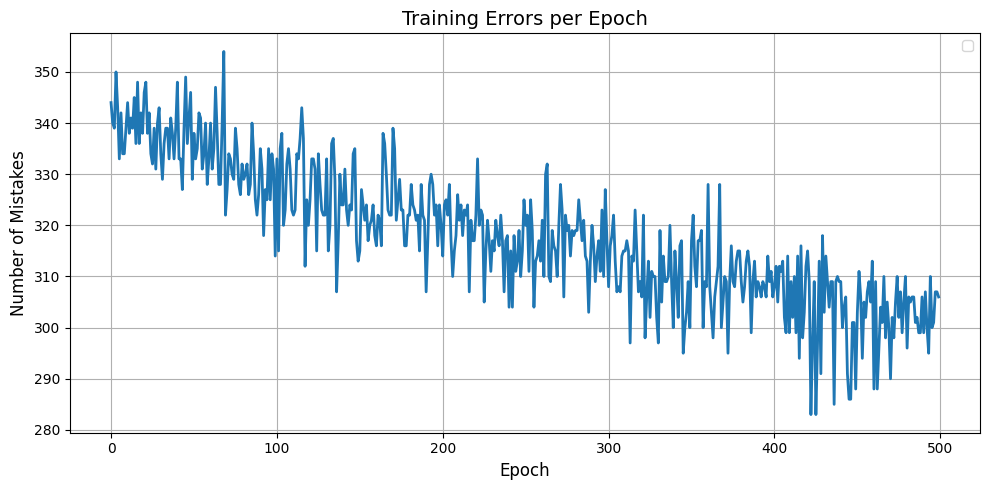

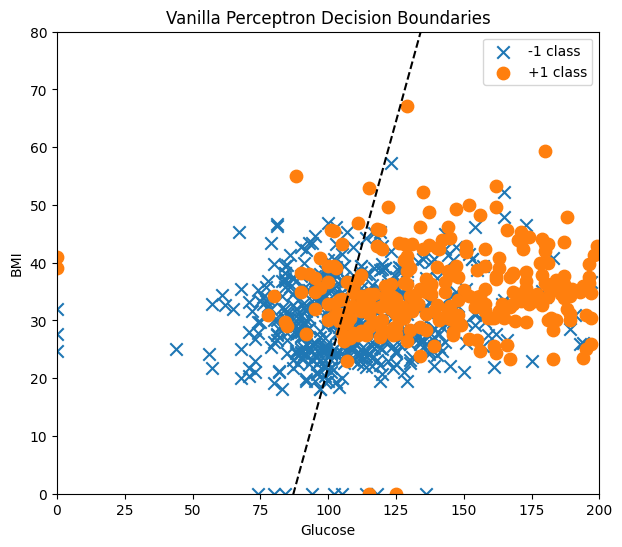

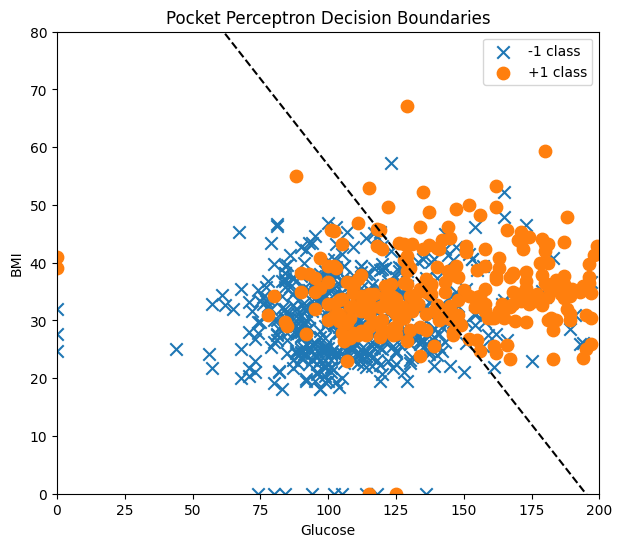

In [88]:
# Train both perceptrons
b_v, w1_v, w2_v, vanilla_mistakes = vanilla_perceptron(data, learning_rate, num_epochs)
b_p, w1_p, w2_p, pocket_mistakes = pocket_perceptron(data, learning_rate, num_epochs)

plt.figure(figsize=(10, 5))
plt.plot(vanilla_mistakes, linewidth=2)

# plot training errors per epoch
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Number of Mistakes', fontsize=12)
plt.title('Training Errors per Epoch', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot vanilla decision boundary
fig, ax = plt.subplots(figsize=(7, 6))
ax.set_xlim(AX[0], AX[1]); ax.set_ylim(AX[2], AX[3])
plot_points(ax)
plot_boundary(ax, b_v, w1_v, w2_v)
ax.legend(['-1 class', '+1 class'])
ax.set_xlabel("Glucose")
ax.set_ylabel("BMI")
ax.set_title("Vanilla Perceptron Decision Boundaries")
plt.show()

# Plot pocket decision boundary
fig, ax = plt.subplots(figsize=(7, 6))
ax.set_xlim(AX[0], AX[1]); ax.set_ylim(AX[2], AX[3])
plot_points(ax)
plot_boundary(ax, b_p, w1_p, w2_p)
ax.legend(['-1 class', '+1 class'])
ax.set_xlabel("Glucose")
ax.set_ylabel("BMI")
ax.set_title("Pocket Perceptron Decision Boundaries")
plt.show()

# Training Results
Plot training data with decision boundaries for both models. Report empirical error and confusion matrices

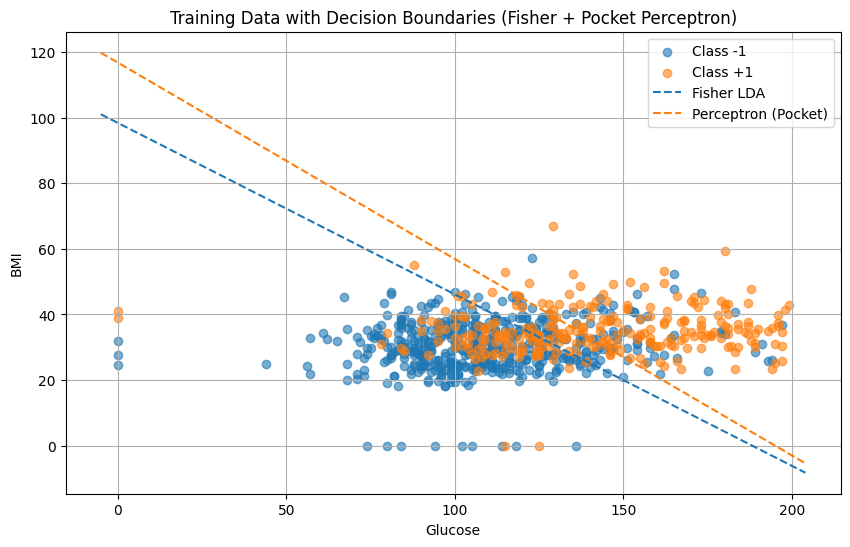

Empirical Error - Fisher: 26.17%
Empirical Error - Pocket Perceptron: 22.66%


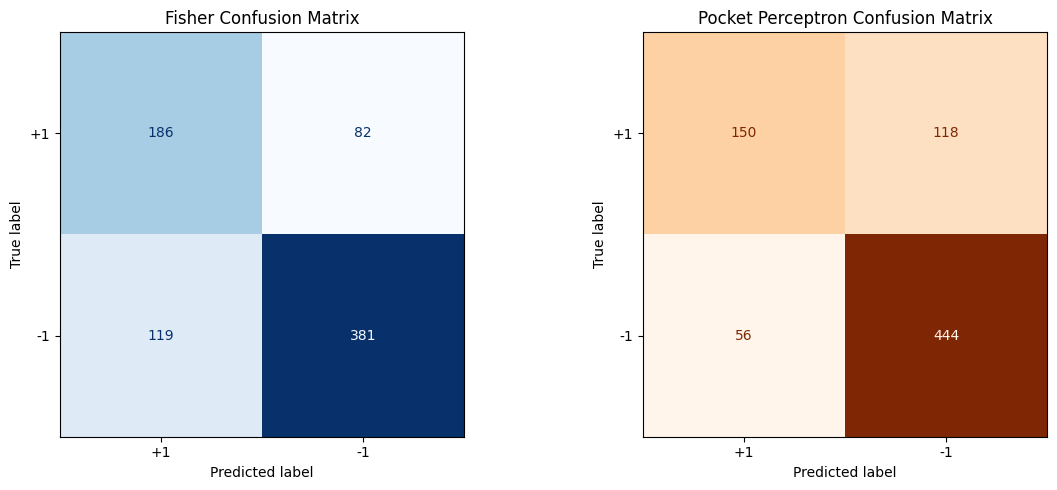

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_train = outcome 
X_train = np.column_stack((glucose, bmi))

# Function to plot decision boundary
def plot_decision_boundary(w, b, ax, label):
    """w can be 2-element array or tuple, b is bias."""
    x_vals = np.linspace(min(glucose)-5, max(glucose)+5, 200)
    
    if len(w) == 2:
        # General line: w1*x + w2*y + b = 0 => y = -(b + w1*x)/w2
        if np.isclose(w[1],0):
            # Vertical line
            ax.axvline(x=-b/w[0], linestyle='--', label=label)
        else:
            y_vals = -(b + w[0]*x_vals)/w[1]
            ax.plot(x_vals, y_vals, linestyle='--', label=label)

# Prepare figure
plt.figure(figsize=(10,6))
plt.scatter(X_train[y_train==-1, 0], X_train[y_train==-1, 1], label='Class -1', alpha=0.6)
plt.scatter(X_train[y_train==1,  0], X_train[y_train==1,  1], label='Class +1', alpha=0.6)

# Plot Fisher decision boundary
plot_decision_boundary(w_fisher, b_fisher, plt.gca(), 'Fisher LDA')

# Plot Perceptron decision boundary
plot_decision_boundary([w1_p, w2_p], b_p, plt.gca(), 'Perceptron (Pocket)')

plt.xlabel('Glucose')
plt.ylabel('BMI')
plt.title('Training Data with Decision Boundaries (Fisher + Pocket Perceptron)')
plt.legend()
plt.grid(True)
plt.show()

# Fisher predictions
yhat_fisher = np.array([1 if np.dot(w_fisher, x)+b_fisher >= 0 else -1 for x in X_train])

# Perceptron predictions
yhat_perc = np.array([1 if np.dot([w1_p, w2_p], x)+b_p >= 0 else -1 for x in X_train])

emp_error_fisher = np.mean(yhat_fisher != y_train)
emp_error_perc = np.mean(yhat_perc != y_train)

print(f"Empirical Error - Fisher: {emp_error_fisher*100:.2f}%")
print(f"Empirical Error - Pocket Perceptron: {emp_error_perc*100:.2f}%")

cm_fisher = confusion_matrix(y_train, yhat_fisher, labels=[1,-1])
cm_perc   = confusion_matrix(y_train, yhat_perc, labels=[1,-1])

fig, axes = plt.subplots(1, 2, figsize=(12,5))
disp_fisher = ConfusionMatrixDisplay(confusion_matrix=cm_fisher, display_labels=['+1','-1'])
disp_fisher.plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title("Fisher Confusion Matrix")

disp_perc = ConfusionMatrixDisplay(confusion_matrix=cm_perc, display_labels=['+1','-1'])
disp_perc.plot(ax=axes[1], cmap='Oranges', colorbar=False)
axes[1].set_title("Pocket Perceptron Confusion Matrix")

plt.tight_layout()
plt.show()

# Validation Results
Apply both models to the specified train/test split set. Report accuracy, sensitivity, and specificity (LSD-1 = 1 --> 80/20 train/test split)

In [90]:
from sklearn.model_selection import train_test_split

y = outcome
X = np.column_stack((glucose, bmi))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# train fisher and perceptron models on training set
num_epochs = 500
learning_rate = 1

data = list(zip(X_train, y_train))

b_p, w1_p, w2_p, mistakes = pocket_perceptron(data, learning_rate, num_epochs)
w_f, b_f, X_A_train, X_B_train = fisher_train(X_train, y_train)

# predictions on test set
yhat_f = fisher_predict(X_test, w_f, b_f)
yhat_p = perceptron_predict(X_test, [w1_p, w2_p], b_p)

# calculate accuracies
acc_fisher = np.mean(yhat_f == y_test) * 100
acc_perceptron = np.mean(yhat_p == y_test) * 100

# calculate sensitivity and specificity
def sensitivity_specificity(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == -1) & (y_pred == -1))
    fp = np.sum((y_true == -1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == -1))
    
    # people who have the disease
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

    # people who do not have the disease
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    return sensitivity, specificity

sens_fisher = sensitivity_specificity(y_test, yhat_f)
sens_perceptron = sensitivity_specificity(y_test, yhat_p)
print(f"Fisher Test Accuracy: {acc_fisher:.2f}%, Sensitivity: {sens_fisher[0]:.2f}, Specificity: {sens_fisher[1]:.2f}")
print(f"Perceptron Test Accuracy: {acc_perceptron:.2f}%, Sensitivity: {sens_perceptron[0]:.2f}, Specificity: {sens_perceptron[1]:.2f}")

Epoch 1: 290 misclassified
Epoch 2: 291 misclassified
Epoch 3: 289 misclassified
Epoch 4: 287 misclassified
Epoch 5: 288 misclassified
Epoch 6: 285 misclassified
Epoch 7: 280 misclassified
Epoch 8: 286 misclassified
Epoch 9: 287 misclassified
Epoch 10: 281 misclassified
Epoch 11: 283 misclassified
Epoch 12: 278 misclassified
Epoch 13: 289 misclassified
Epoch 14: 291 misclassified
Epoch 15: 288 misclassified
Epoch 16: 288 misclassified
Epoch 17: 288 misclassified
Epoch 18: 295 misclassified
Epoch 19: 286 misclassified
Epoch 20: 283 misclassified
Epoch 21: 278 misclassified
Epoch 22: 289 misclassified
Epoch 23: 284 misclassified
Epoch 24: 288 misclassified
Epoch 25: 284 misclassified
Epoch 26: 280 misclassified
Epoch 27: 282 misclassified
Epoch 28: 282 misclassified
Epoch 29: 293 misclassified
Epoch 30: 289 misclassified
Epoch 31: 284 misclassified
Epoch 32: 296 misclassified
Epoch 33: 290 misclassified
Epoch 34: 285 misclassified
Epoch 35: 284 misclassified
Epoch 36: 289 misclassified
E

# Visualization of Projection and Learning

(a) Plot 1-D FLD projections with class histograms
and threshold. (b) Plot Perceptron error vs. epoch

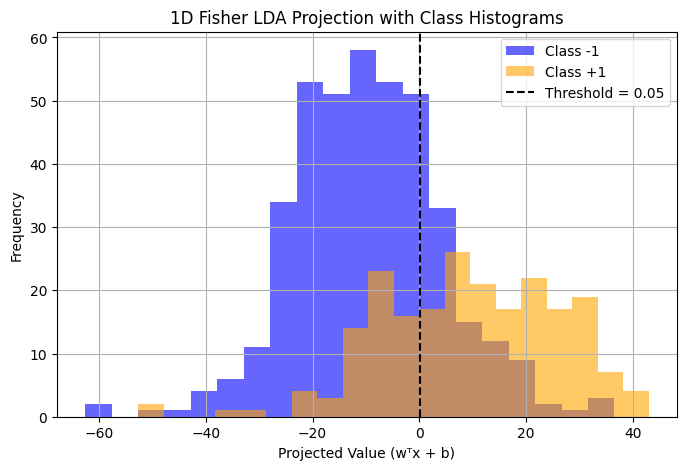

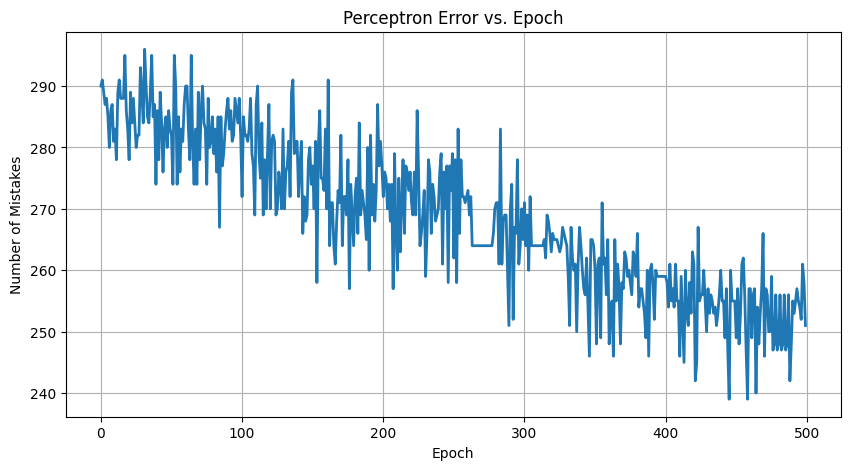

In [91]:
# Project data onto Fisher direction
proj = X_train @ w_fisher + b_fisher

# Separate projections by class
proj_class_neg = proj[y_train == -1]
proj_class_pos = proj[y_train == 1]

# Compute a simple threshold — e.g. midpoint between class means
thresh = (np.mean(proj_class_neg) + np.mean(proj_class_pos)) / 2

plt.figure(figsize=(8,5))
plt.hist(proj_class_neg, bins=20, alpha=0.6, label='Class -1', color='blue')
plt.hist(proj_class_pos, bins=20, alpha=0.6, label='Class +1', color='orange')
plt.axvline(thresh, color='k', linestyle='--', label=f'Threshold = {thresh:.2f}')

plt.title('1D Fisher LDA Projection with Class Histograms')
plt.xlabel('Projected Value (wᵀx + b)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Plot Perceptron error from training set vs. epoch
plt.figure(figsize=(10,5))
plt.plot(mistakes, linewidth=2)
plt.title('Perceptron Error vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Number of Mistakes')
plt.grid(True)
plt.show()